In [2]:
import itertools
import numpy as np
import pandas as pd
import proplot as pplt
import os
import pyproj
import sys
import warnings
import xarray as xr
# sys.path.append('/Users/dwatkin2/Documents/research/packages/buoy_processing/')
sys.path.append('../scripts/')
from scipy.interpolate import interp2d
from drifter import compute_velocity
from drifter import compute_along_across_components
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

#### Specify locations for data.
# External datasets not included in archive are stored in a lower 
# sic_loc = '../../../data/nsidc_daily_cdr/'
# motion_loc = '../../../data/nsidc_daily_icemotion/'
ift_loc = '../data/floe_tracker/ift_with_era5.csv'
df_ift = pd.read_csv(ift_loc, index_col=0)
df_ift.drop('Unnamed: 1', axis=1, inplace=True)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)
sic = df_ift['sea_ice_concentration']
df_ift.loc[sic > 1, 'sea_ice_concentration'] = np.nan

# Additional filter
# I think I added this into the prep script
speed = np.sqrt(df_ift.loc[df_ift.qc_flag==0, 'u']**2 + df_ift.loc[df_ift.qc_flag==0, 'v']**2)
mean_u = df_ift.loc[df_ift.qc_flag==0, 'u'].mean()
mean_v = df_ift.loc[df_ift.qc_flag==0, 'v'].mean()

z = np.sqrt((df_ift.u - mean_u)**2 + (df_ift.v - mean_v)**2)/np.std(speed)
df_ift.loc[np.abs(z) > 6, 'qc_flag'] = 1
df_filtered = df_ift.loc[df_ift.qc_flag==0]

df_filtered['L'] = np.sqrt(df_filtered['area'])
df_filtered['l_bin'] = np.digitize(df_filtered['L'], bins=np.arange(0, 60, 5))
df_filtered['l_center'] = [pd.Series(np.arange(2.5, 63, 5), index=np.arange(1, 14))[x] for x in df_filtered['l_bin']]
subset = df_filtered.loc[(df_filtered.qc_flag == 0) & df_filtered.zeta.notnull()]

In [15]:
df_cyc = subset.where(subset.zeta > 0).dropna().pivot_table(
    columns='l_center', values='zeta', index='floe_id')
df_anticyc = -subset.where(subset.zeta < 0).dropna().pivot_table(
    columns='l_center', values='zeta', index='floe_id')

idx_cyc = df_cyc.notnull().sum(axis=0) > 100
idx_anticyc = df_anticyc.notnull().sum(axis=0) > 100

df_cyc = df_cyc.loc[:, idx_cyc].copy()
df_anticyc = df_anticyc.loc[:, idx_anticyc].copy()

In [25]:
print(df_cyc.notnull().sum(axis=0))

l_center
2.5      577
7.5     3421
12.5    1115
17.5     375
22.5     131
dtype: int64


In [5]:
sim_rot = pd.read_csv('../data/simulation/rotation_rates.csv')
sim_rot.columns = [c.replace('km', '') for c in sim_rot.columns]
sr_melted = sim_rot.melt()
sr_melted['variable'] = sr_melted['variable'].astype(int)
sr_melted.columns = ['length_scale', 'rotation_rate']
sr_melted['L'] = np.sqrt(np.pi*(sr_melted['length_scale'])**2)

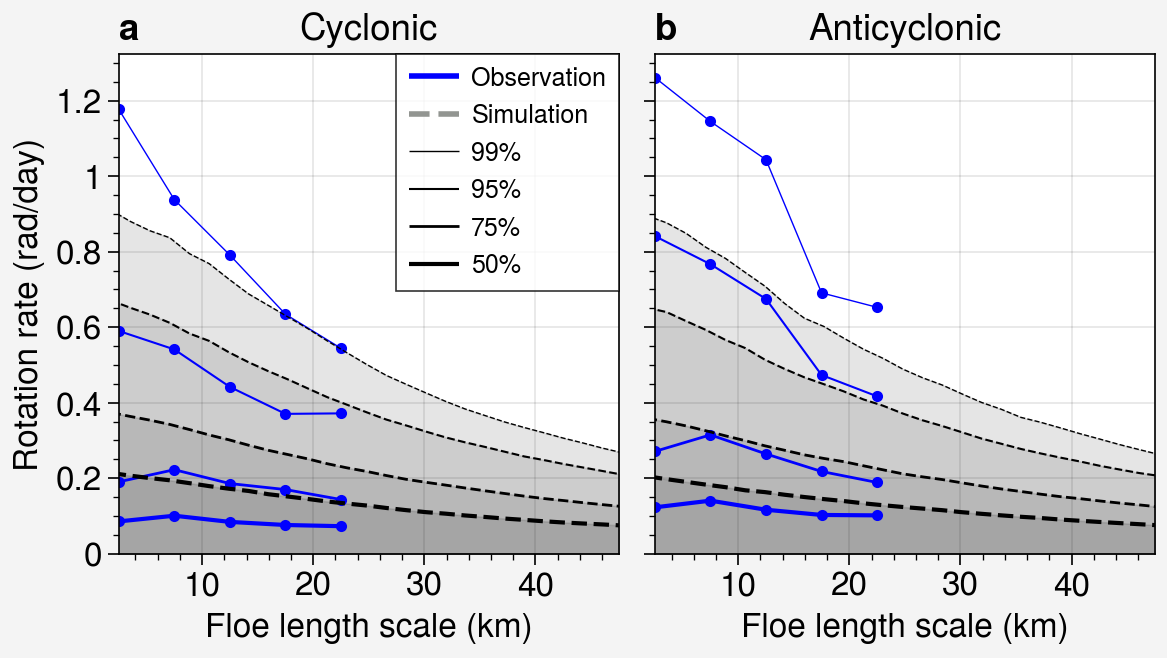

In [27]:
fig, axs = pplt.subplots(ncols=2, sharex=False)
R = sim_rot.where(sim_rot > 0).quantile(0.99, axis=0).interpolate().index.astype(int)
L = np.sqrt(np.pi)*R

for q, lw, m in zip([0.99, 0.95, 0.75, 0.5],
                        [0.5, 0.75, 1, 1.5],
                   ['', '', '', '']):
    

    axs[0].plot(df_cyc.columns, df_cyc.quantile(q, axis=0).interpolate(),
                color='b', lw=lw, marker='.', ls='-')
    axs[1].plot(df_anticyc.columns, df_anticyc.quantile(q, axis=0).interpolate(),
                color='b', lw=lw, ls='-', m='.')

    axs[0].plot(L, sim_rot.where(sim_rot > 0).quantile(q, axis=0).interpolate(),
                color='k', lw=lw, ls='--', marker=m)
    axs[0].area(L, sim_rot.where(sim_rot > 0).quantile(q, axis=0).interpolate(),
               alpha=0.1, color='k')

    
    axs[1].plot(L, (-sim_rot.where(sim_rot < 0)).quantile(q, axis=0).interpolate(),
                color='k', lw=lw, ls='--', marker=m)
    axs[1].area(L, (-sim_rot.where(sim_rot < 0)).quantile(q, axis=0).interpolate(),
               alpha=0.1, color='k')

axs[0].format(xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)',
           ylabel='Rotation rate (rad/day)', xlim=(2.5, 47.5))
axs[1].format(xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)',
           ylabel='Rotation rate (rad/day)', xlim=(2.5, 47.5))


axs[0].format(title='Cyclonic')
axs[1].format(title='Anticyclonic')
#     suptitle='Floe rotation rate distribution by length scale',)

# Legend
l = ['Observation', 'Simulation',
     '99%', '95%', '75%', '50%']
h = [axs[0].plot([],[],c=c, lw=lw, m='', ls=ls)
     for c, lw, ls in zip(['b', 'gray', 'k', 'k', 'k', 'k'],
                         [2, 2, 0.5, 0.75, 1, 1.5], ['-', '--', '-', '-', '-', '-'])]
axs[0].legend(h, l, ncols=1)
fig.format(fontsize=12, abc=True)
fig.save('../figures/fig05_rotation_rate_distribution.pdf', dpi=300)

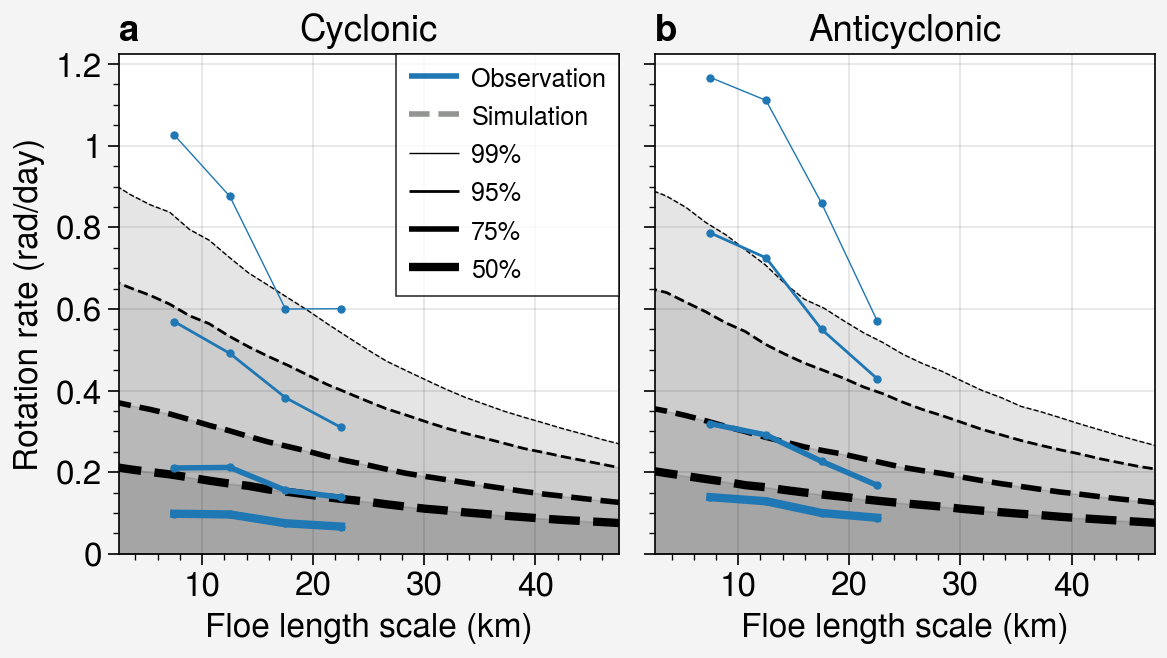

In [2]:
%run ../scripts/08_plot_rotation_dist.py

In [84]:
f = 2*(7.292e-5)*np.sin(np.deg2rad(subset['latitude']))
subset['normalized_rotation'] = subset['zeta']/(f * 24*60*60)

df_summary = subset.loc[:, ['l_bin', 'normalized_rotation', 'zeta']].groupby('l_bin').quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])
df_summary.reset_index(inplace=True)
df_summary.columns=['l_bin', 'quantile', 'normalized_rotation', 'zeta']
df_summary_zeta = df_summary.pivot_table(index='l_bin', columns='quantile', values='zeta')
df_summary_omega = df_summary.pivot_table(index='l_bin', columns='quantile', values='normalized_rotation')

x = df[['l_bin', 'length_scale_km']].groupby('l_bin').median()
df_summary_zeta.index = x.loc[df_summary_zeta.index].values.squeeze()
df_summary_omega.index = x.loc[df_summary_omega.index].values.squeeze()

In [50]:
x.loc[df_summary_zeta.index].values.squeeze()

array([ 5.96783041,  9.73909647, 14.83644162, 19.87863174, 24.63473158,
       29.73079212, 34.43938177, 39.93756035, 47.10785497, 48.51236629,
       55.66650699])

In [56]:
df_summary_zeta.index = x.loc[df_summary_zeta.index].values.squeeze()

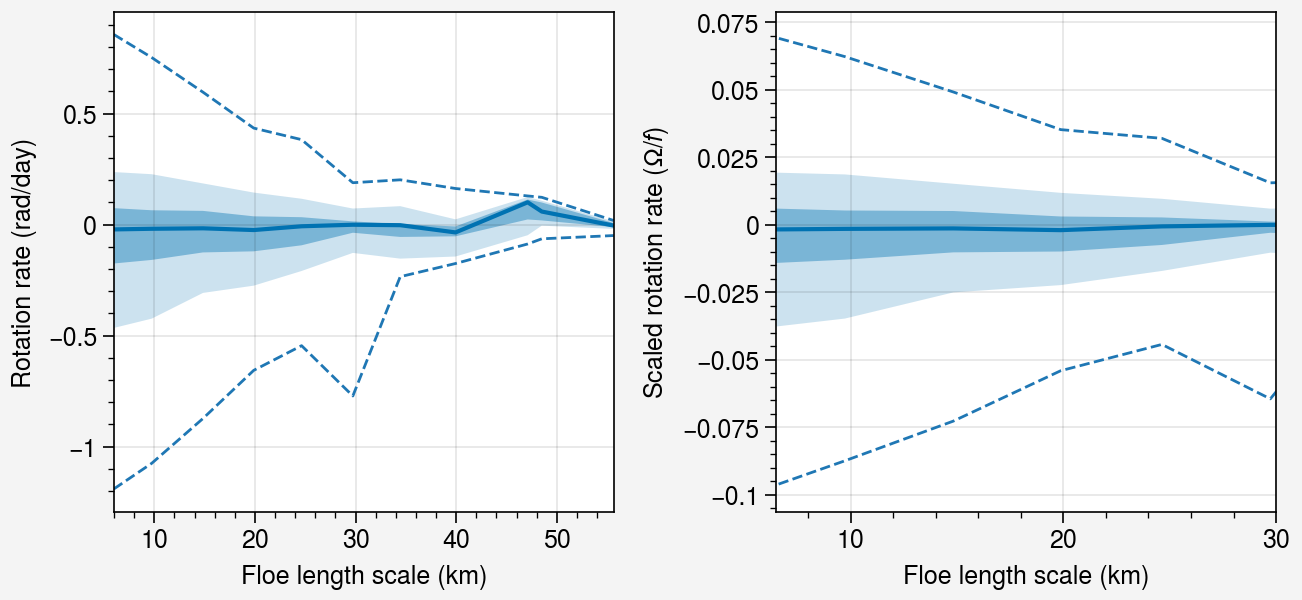

In [90]:


fig, axs = pplt.subplots(ncols=2, share=False)
ax = axs[0]
ax.plot(df_summary_zeta[0.01], ls='--', lw=1, color='tab:blue')
ax.plot(df_summary_zeta[0.99], ls='--', lw=1, color='tab:blue')

ax.plot(df_summary_zeta[0.5], shadedata=[df_summary_zeta[0.25], df_summary_zeta[0.75]],
        fadedata=[df_summary_zeta[0.1], df_summary_zeta[0.9]])
ax.format(ylabel='Rotation rate (rad/day)',
          xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)')
ax = axs[1]
ax.plot(df_summary_omega[0.01], ls='--', lw=1, color='tab:blue')
ax.plot(df_summary_omega[0.99], ls='--', lw=1, color='tab:blue')

ax.plot(df_summary_omega[0.5], shadedata=[df_summary_omega[0.25], df_summary_omega[0.75]],
        fadedata=[df_summary_omega[0.1], df_summary_omega[0.9]])
ax.format(ylabel='Scaled rotation rate ($\\Omega/f$)',
          xlocator=np.arange(10, 31, 10), xlim=(6.5, 30),
          xlabel='Floe length scale (km)')

# The goal of the figure
Previously we show that overall, there is a dependence on length scale. However we know that the sea ice concentration and the distance to the ice edge/coast and the time of year all play a role here.

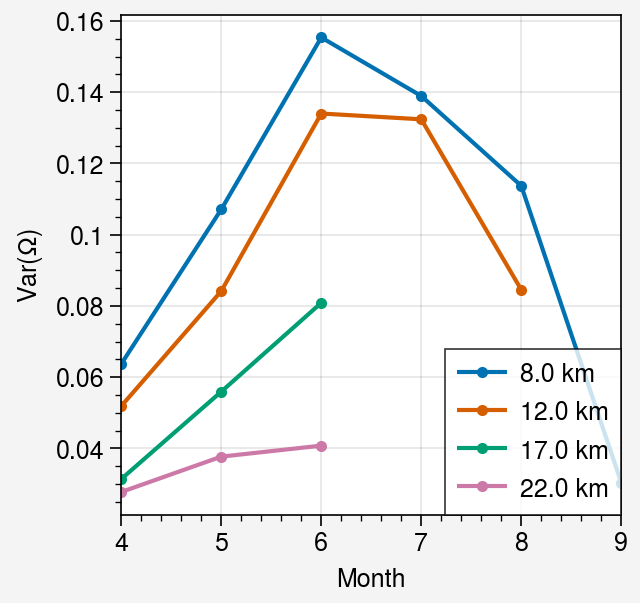

In [118]:
subset['month'] = subset.datetime.dt.month
fig, ax = pplt.subplots()
for bin_num in range(2, 9):
    L = subset.loc[subset.l_bin==bin_num, 'L'].mean()
    v = subset.loc[subset.l_bin==bin_num, ['month', 'zeta']].groupby('month').var()
    n = counts[bin_num]
    if sum(n > 200) > 1:
        ax.plot(v.where(n > 200), label=str(np.round(L, 0)) + ' km', marker='.')
ax.legend(ncols=1)
ax.format(ylabel='Var($\\Omega$)', xlabel='Month')

In [120]:
pack_subset = subset.loc[subset.nsidc_sic >= 0.85]
miz_subset = subset.loc[subset.nsidc_sic < 0.85]
miz_subset.groupby('month').count()

,datetime,floe_id,longitude,latitude,x_stere,y_stere,area,perimeter,axis_major_length,axis_minor_length,...,u15D_nsidc,v15D_nsidc,u31D_nsidc,v31D_nsidc,area_adj_km2,L,qc_flag,l_bin,l_center,normalized_rotation
month,,,,,,,,,,,,,,,,,,,,,
4,831,831,831,831,831,831,831,831,831,831,...,785,785,786,786,831,831,831,831,831,831
5,2423,2423,2423,2423,2423,2423,2423,2423,2423,2423,...,2159,2159,2159,2159,2423,2423,2423,2423,2423,2423
6,5609,5609,5609,5609,5609,5609,5609,5609,5609,5609,...,5076,5076,5081,5081,5609,5609,5609,5609,5609,5609
7,1517,1517,1517,1517,1517,1517,1517,1517,1517,1517,...,1358,1358,1375,1375,1517,1517,1517,1517,1517,1517
8,629,629,629,629,629,629,629,629,629,629,...,520,520,546,546,629,629,629,629,629,629
9,104,104,104,104,104,104,104,104,104,104,...,66,66,69,69,104,104,104,104,104,104


In [121]:
pack_subset.groupby('month').count()

,datetime,floe_id,longitude,latitude,x_stere,y_stere,area,perimeter,axis_major_length,axis_minor_length,...,u15D_nsidc,v15D_nsidc,u31D_nsidc,v31D_nsidc,area_adj_km2,L,qc_flag,l_bin,l_center,normalized_rotation
month,,,,,,,,,,,,,,,,,,,,,
4,12094,12094,12094,12094,12094,12094,12094,12094,12094,12094,...,11102,11102,11102,11102,12094,12094,12094,12094,12094,12094
5,11830,11830,11830,11830,11830,11830,11830,11830,11830,11830,...,10789,10789,10789,10789,11830,11830,11830,11830,11830,11830
6,8438,8438,8438,8438,8438,8438,8438,8438,8438,8438,...,7801,7801,7801,7801,8438,8438,8438,8438,8438,8438
7,974,974,974,974,974,974,974,974,974,974,...,807,807,807,807,974,974,974,974,974,974
8,391,391,391,391,391,391,391,391,391,391,...,262,262,262,262,391,391,391,391,391,391
9,379,379,379,379,379,379,379,379,379,379,...,225,225,225,225,379,379,379,379,379,379


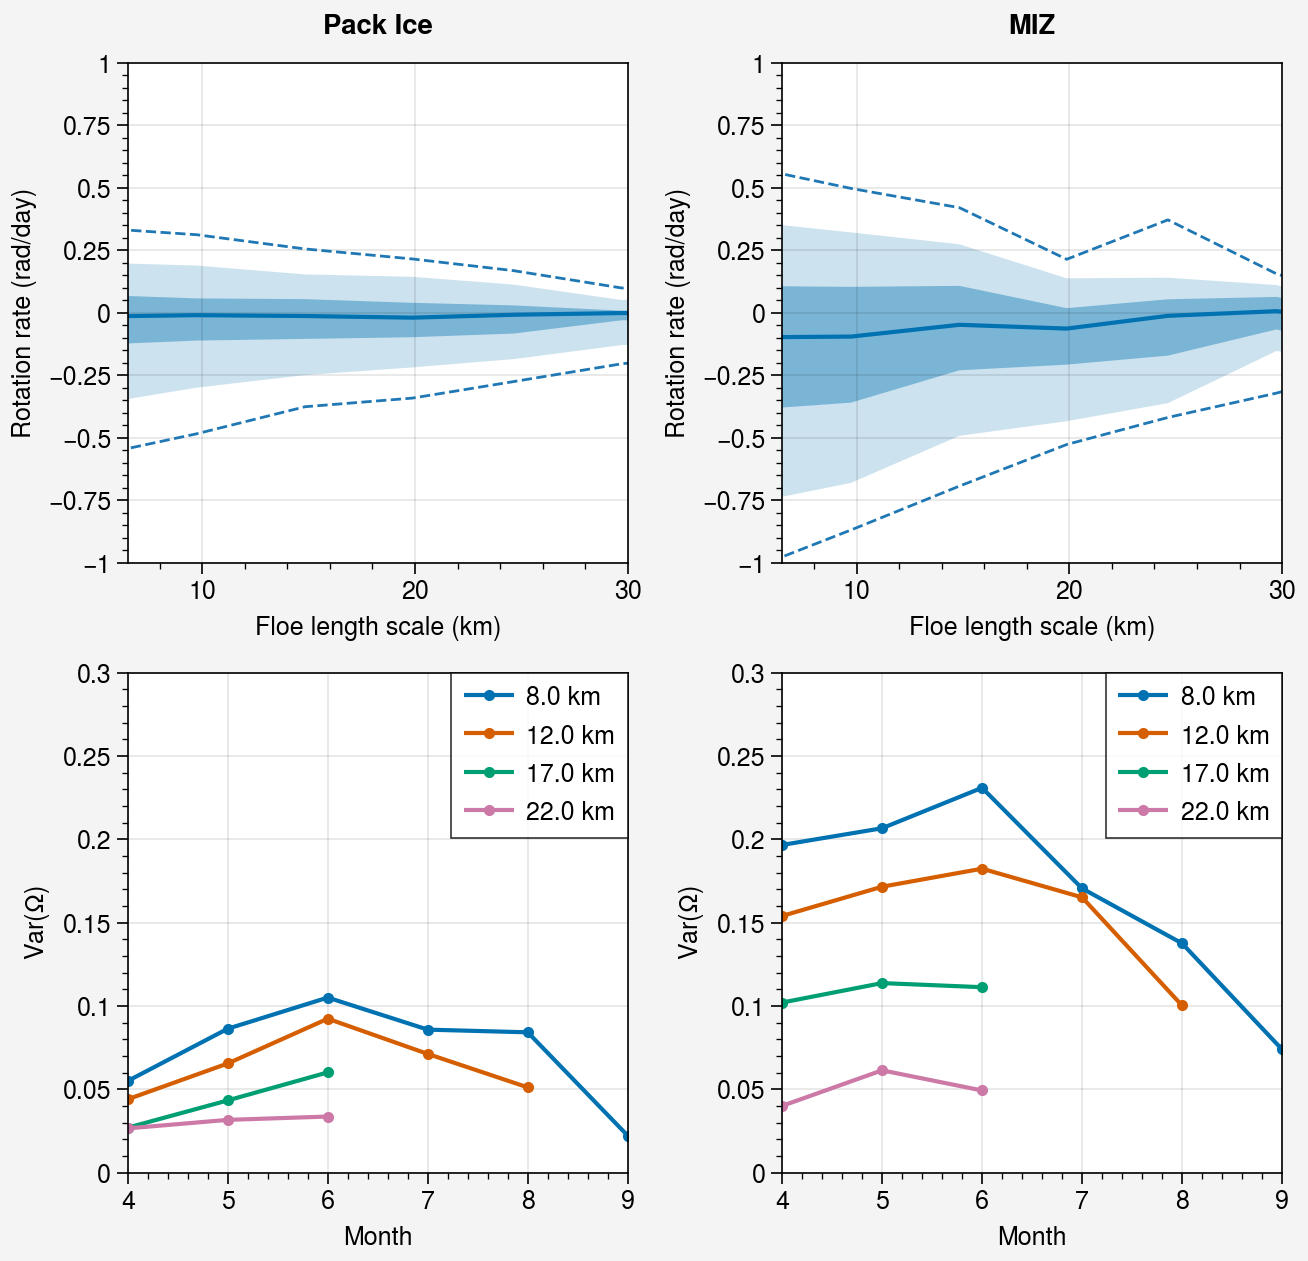

In [148]:
f = 2*(7.292e-5)*np.sin(np.deg2rad(subset['latitude']))

pack_summary = pack_subset.loc[:, ['l_bin', 'zeta']].groupby('l_bin').quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95])
pack_summary.reset_index(inplace=True)
pack_summary.columns=['l_bin', 'quantile', 'zeta']
pack_summary = pack_summary.pivot_table(index='l_bin', columns='quantile', values='zeta')

x = df[['l_bin', 'length_scale_km']].groupby('l_bin').median()
pack_summary.index = x.loc[pack_summary.index].values.squeeze()

miz_summary = miz_subset.loc[:, ['l_bin', 'zeta']].groupby('l_bin').quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95])
miz_summary.reset_index(inplace=True)
miz_summary.columns=['l_bin', 'quantile', 'zeta']
miz_summary = miz_summary.pivot_table(index='l_bin', columns='quantile', values='zeta')

x = df[['l_bin', 'length_scale_km']].groupby('l_bin').median()
miz_summary.index = x.loc[miz_summary.index].values.squeeze()

fig, axs = pplt.subplots(ncols=2, nrows=2, share=False)
for data, ax in zip([pack_summary, miz_summary], axs[0,:]):
    ax.plot(data[0.05], ls='--', lw=1, color='tab:blue')
    ax.plot(data[0.95], ls='--', lw=1, color='tab:blue')
    
    ax.plot(data[0.5], shadedata=[data[0.25], data[0.75]],
            fadedata=[data[0.1], data[0.9]])
    ax.format(ylabel='Rotation rate (rad/day)', ylim=(-1, 1),
              xlocator=np.arange(10, 31, 10), xlim=(6.5, 30),
              xlabel='Floe length scale (km)')
for data, ax in zip([pack_subset, miz_subset], axs[1,:]):
    for bin_num in range(2, 9):
        L = data.loc[data.l_bin==bin_num, 'L'].mean()
        v = data.loc[data.l_bin==bin_num, ['month', 'zeta']].groupby('month').var()
        n = counts[bin_num]
        if sum(n > 200) > 1:
            ax.plot(v.where(n > 200), label=str(np.round(L, 0)) + ' km', marker='.')

    ax.legend(ncols=1, loc='ur')
    ax.format(ylabel='Var($\\Omega$)', xlabel='Month', ylim=(0, 0.3))
axs.format(toplabels=['Pack Ice', 'MIZ'])

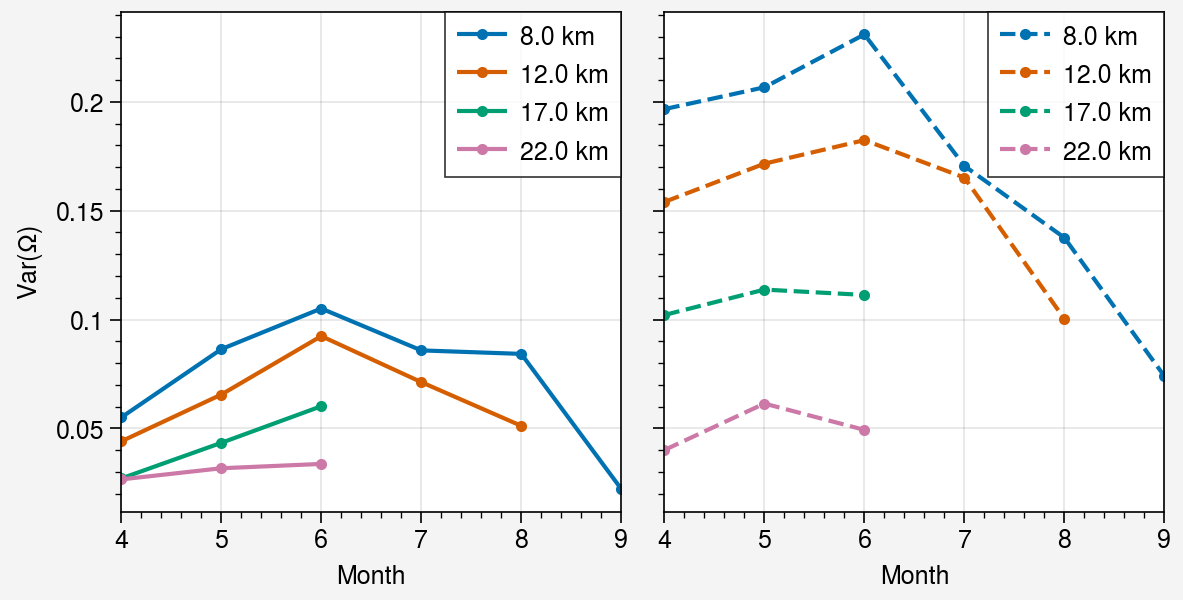

In [127]:
fig, ax = pplt.subplots(ncols=2, sharex=False)
for bin_num in range(2, 9):
    L = pack_subset.loc[pack_subset.l_bin==bin_num, 'L'].mean()
    v = pack_subset.loc[pack_subset.l_bin==bin_num, ['month', 'zeta']].groupby('month').var()
    n = counts[bin_num]
    if sum(n > 200) > 1:
        ax[0].plot(v.where(n > 200), label=str(np.round(L, 0)) + ' km', marker='.')

    L = miz_subset.loc[miz_subset.l_bin==bin_num, 'L'].mean()
    v = miz_subset.loc[miz_subset.l_bin==bin_num, ['month', 'zeta']].groupby('month').var()
    n = counts[bin_num]
    if sum(n > 200) > 1:
        ax[1].plot(v.where(n > 200), label=str(np.round(L, 0)) + ' km', marker='.', ls='--')


ax.legend(ncols=1, loc='ur')
ax.format(ylabel='Var($\\Omega$)', xlabel='Month')

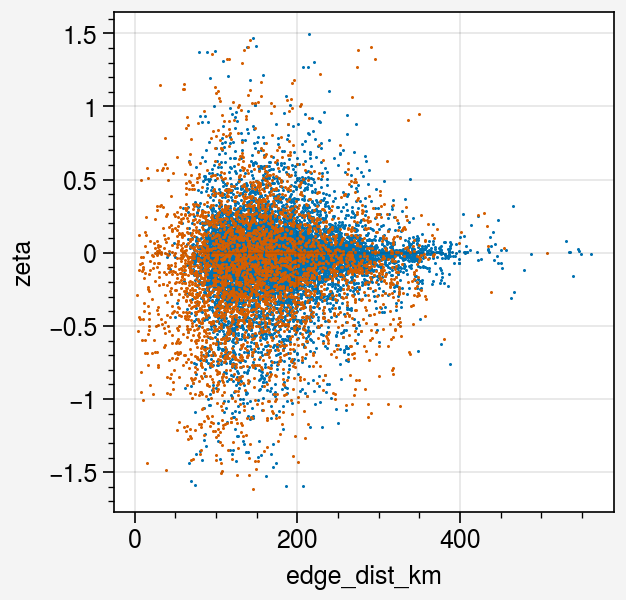

In [130]:
fig, ax = pplt.subplots()
ax.scatter(pack_subset.loc[pack_subset.l_bin==3, 'edge_dist_km'],
           pack_subset.loc[pack_subset.l_bin==3, 'zeta'], marker='.', ms=1)
ax.scatter(miz_subset.loc[miz_subset.l_bin==3, 'edge_dist_km'],
           miz_subset.loc[miz_subset.l_bin==3, 'zeta'], marker='.', ms=1)

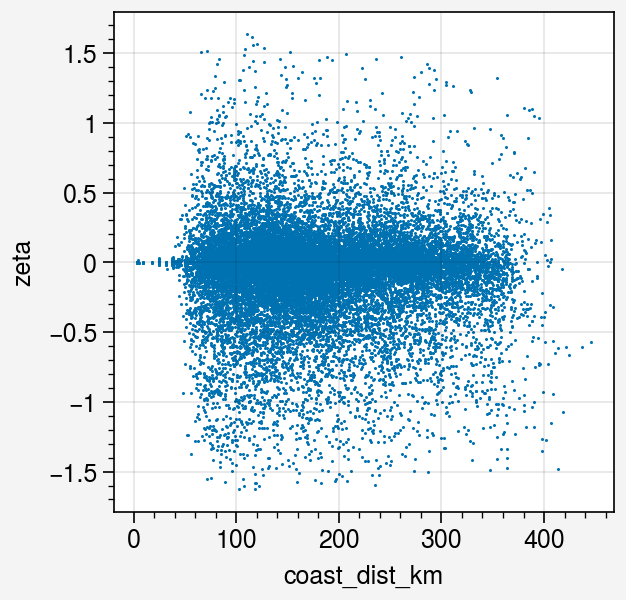

In [113]:
fig, ax = pplt.subplots()
ax.scatter(subset.loc[subset.l_bin==2, 'coast_dist_km'],
           subset.loc[subset.l_bin==2, 'zeta'], marker='.', ms=1)

Monthly mean

In [ ]:
df_summary = df.loc[:, ['l_bin', 'zeta']].groupby('l_bin').std()
df_summary.reset_index(inplace=True)
df_summary.columns=['l_bin', 'quantile', 'zeta']
df_summary_zeta = df_summary.pivot_table(index='l_bin', columns='std', values='zeta')
x = df[['l_bin', 'length_scale_km']].groupby('l_bin').median()
df_summary_zeta.index = x.loc[df_summary_zeta.index].values.squeeze()

In [97]:
counts


l_bin,2,3,4,5,6,7,8,9,10,11,12
datetime,,,,,,,,,,,
4,6670.0,4173.0,1270.0,554.0,221.0,59.0,38.0,12.0,5.0,6.0,9.0
5,7088.0,4761.0,1534.0,560.0,195.0,121.0,59.0,4.0,5.0,1.0,NaN
6,7596.0,4587.0,1264.0,401.0,141.0,50.0,43.0,8.0,5.0,3.0,2.0
7,1526.0,738.0,180.0,33.0,13.0,29.0,2.0,NaN,NaN,NaN,NaN
8,545.0,327.0,107.0,32.0,14.0,27.0,2.0,2.0,NaN,NaN,NaN
9,253.0,177.0,44.0,15.0,5.0,5.0,2.0,NaN,NaN,NaN,NaN


NameError: name 'dr' is not defined

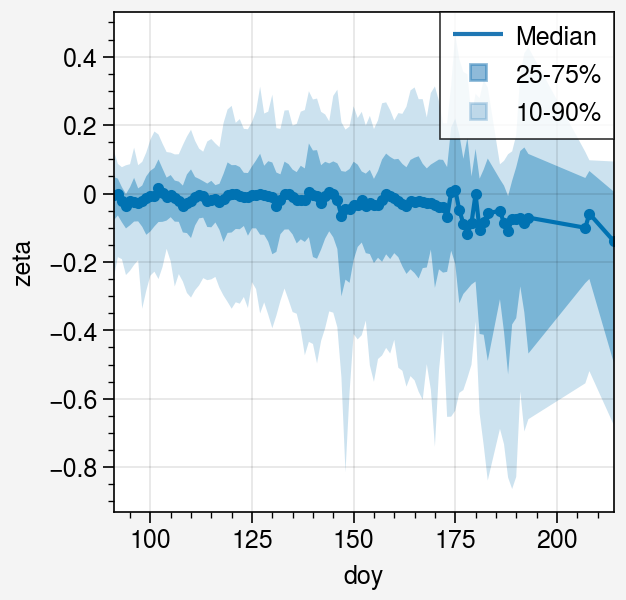

In [69]:
df = subset.copy()
var = 'zeta'
df['month'] = df.datetime.dt.month
df['n'] = df.groupby('datetime').transform(lambda x: len(x))['area']
df['length_scale_km'] = df['area_km2']**0.5
df['doy'] = df.datetime.dt.dayofyear
idx = df.n > 30
# idx = idx & df.area_adj_km.between(41, 90e3)
# idx = idx & df.lr_classification
n = df.loc[idx, [var, 'doy']].groupby('doy').count()
med = df.loc[idx, [var, 'doy']].groupby('doy').median()
p90 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.90)
p10 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.10)
p75 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.75)
p25 = df.loc[idx, [var, 'doy']].groupby('doy').quantile(0.25)


fig, ax = pplt.subplots()
ax.plot(med[var], fadedata=[p90[var], p10[var]],
        shadedata=[p75[var], p25[var]], marker='.', label='')
h = []
for alpha, ls, m in zip([1, 0.5, 0.25], ['-', '', ''], ['', 's', 's']):
    h.append(ax.plot([],[],color='tab:blue', alpha=alpha, ls=ls, m=m))
ax.legend(h, ['Median', '25-75%', '10-90%'], ncols=1, loc='ur')

ax.format(ylabel='L (km)', xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', title='Floe length scale', fontsize=12, xrotation=45, xlim=(85, 265))


In [60]:
counts = subset.groupby([subset.datetime.dt.month, subset.l_bin]).count()['zeta'].reset_index().pivot_table(index='datetime', columns='l_bin', values='zeta')

In [80]:
f = 2*(7.292e-5)*np.sin(np.deg2rad(subset['latitude']))
subset['normalized_rotation'] = subset['zeta']/(f * 24*60*60)
normalized_variance = subset.loc[:, ['l_bin', 'zeta', 'normalized_rotation']].groupby('l_bin').var()


In [82]:
subset['normalized_rotation']

0      -0.000011
1      -0.000300
2      -0.000329
6      -0.006479
7      -0.001838
          ...   
5127   -0.006942
5128   -0.019865
5129   -0.014702
5130   -0.017495
5131   -0.019191
Name: normalized_rotation, Length: 45523, dtype: float64